In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import os
from PIL import Image


In [4]:
import os
from PIL import Image


class DenoisingDataset(Dataset):
    def __init__(self, root_dir, subset='Train', transform=None):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.data = self._load_data_paths()

    def _load_data_paths(self):
        data = []

        # Loop through each object type in the root directory
        for object_type in os.listdir(self.root_dir):
            object_path = os.path.join(self.root_dir, object_type)
            if not os.path.isdir(object_path):
                continue

            # Set paths for each directory
            gt_dir = os.path.join(object_path, self.subset, "GT_clean_image")
            mask_dir = os.path.join(object_path, self.subset, "Defect_mask")
            degraded_dir = os.path.join(object_path, self.subset, "Degraded_image")


            # Loop through each defect type within the GT_clean_image directory
            for defect_type in os.listdir(gt_dir):
                gt_subdir = os.path.join(gt_dir, defect_type)
                degraded_subdir = os.path.join(degraded_dir, defect_type)
                mask_subdir = os.path.join(mask_dir, defect_type)


                # Ensure the defect type exists in all directories
                if not (os.path.isdir(gt_subdir) and os.path.isdir(degraded_subdir) and os.path.isdir(mask_subdir)):
                    continue

                # For each clean image in the defect type, get the corresponding degraded and mask images
                for file_name1, file_name2, file_name3 in zip(sorted(os.listdir(gt_subdir)), sorted(os.listdir(degraded_subdir)), sorted(os.listdir(mask_subdir))):
                    gt_path = os.path.join(gt_subdir, file_name1)
                    degraded_path = os.path.join(degraded_subdir, file_name2)
                    mask_path = os.path.join(mask_subdir, file_name3)


                    # Check if all three files exist
                    if os.path.exists(gt_path) and os.path.exists(degraded_path) and os.path.exists(mask_path):
                        data.append((degraded_path, gt_path, mask_path))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        degraded_path, gt_path, mask_path = self.data[idx]

        # Load images
        degraded_image = Image.open(degraded_path).convert("RGB")
        gt_image = Image.open(gt_path).convert("RGB")
        defect_mask = Image.open(mask_path).convert("L")  # Load mask as grayscale

        # Apply transformations if specified
        if self.transform:
            degraded_image = self.transform(degraded_image)
            gt_image = self.transform(gt_image)
            defect_mask = self.transform(defect_mask)

        return degraded_image, gt_image, defect_mask


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust size as needed for your model
    transforms.ToTensor()
])


In [6]:
# Define the root directory of your dataset
DATASET_PATH = "/kaggle/input/denoising-ds/Denoising_Dataset_train_val"

# Load train and validation datasets across all object categories
train_dataset = DenoisingDataset(DATASET_PATH, subset='Train', transform=transform)
val_dataset = DenoisingDataset(DATASET_PATH, subset='Val', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


In [7]:
print(len(train_dataset))
print(len(val_dataset))

932
88


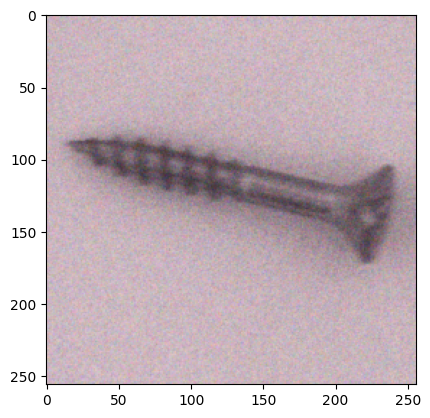

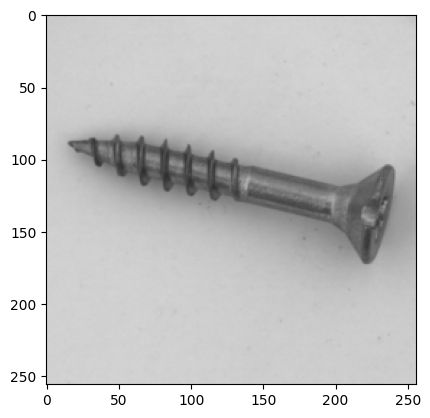

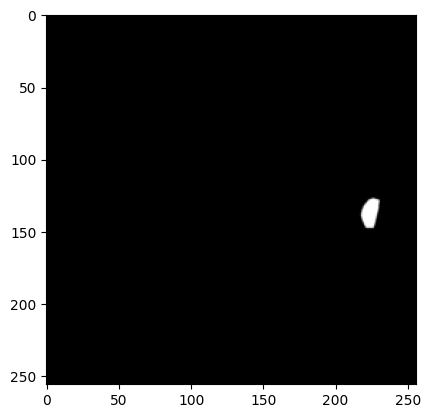

In [8]:
degraded_image, gt_image, defect_mask = train_dataset[100]
plt.imshow(degraded_image.permute(1, 2, 0))
plt.show()
plt.imshow(gt_image.permute(1, 2, 0))
plt.show()
plt.imshow(defect_mask.squeeze(), cmap='gray')
plt.show()

In [9]:
!pip install einops
!pip install thop

In [17]:
import h5py

In [18]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Linear projection of flattened patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # Shape: (batch_size, embed_dim, num_patches ** 0.5, num_patches ** 0.5)
        x = x.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embed_dim)
        return x

class VisionTransformerDenoiser(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer to project back to patch size
        self.output_layer = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

    def forward(self, x):  # (batch_size, 3, 224, 224)

        # Add noise to the input
        noisy_x = x

        # Patch embedding
        patches = self.patch_embed(noisy_x)  # (batch_size, num_patches, embed_dim)

        # Transformer forward pass
        transformed = self.transformer(patches)

        # Project back to original patch size
        reconstructed_patches = self.output_layer(transformed)  # (batch_size, num_patches, patch_size*patch_size*in_channels)
        # Reshape back to the image
        patch_size = int((reconstructed_patches.shape[-1] // in_channels) ** 0.5)
        num_patches_side = int((self.img_size // patch_size))
        reconstructed = (
            reconstructed_patches.view(-1, num_patches_side, num_patches_side, patch_size, patch_size, in_channels)
            .permute(0, 5, 1, 3, 2, 4)
            .contiguous()
            .view(-1, in_channels self.img_size, self.img_size)
        )
        print("Reconstructed image shape:", reconstructed.shape)
        return reconstructed

# Instantiate model
model = VisionTransformerDenoiser(img_size=224, patch_size=16, embed_dim=768, num_heads=12, num_layers=12)

# Test with a sample input
sample_input = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)
output = model(sample_input)

In [20]:

# SSIM Loss in Defect Regions
def ssim_loss_in_defect(img1, img2, defect_mask, C1=0.01 * 2, C2=0.03 * 2):
    mu1 = torch.nn.functional.avg_pool2d(img1, 3, 1, 1)
    mu2 = torch.nn.functional.avg_pool2d(img2, 3, 1, 1)

    sigma1 = torch.nn.functional.avg_pool2d(img1 * 2, 3, 1, 1) - mu1 * 2
    sigma2 = torch.nn.functional.avg_pool2d(img2 * 2, 3, 1, 1) - mu2 * 2
    sigma12 = torch.nn.functional.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 * 2 + mu2 * 2 + C1) * (sigma1 + sigma2 + C2))

    # Apply defect mask to only include defect areas in SSIM calculation
    ssim_in_defect = ssim_map * defect_mask
    return torch.clamp((1 - ssim_in_defect) / 2, 0, 1).mean()

# PSNR Loss over Entire Image
def psnr_loss_in(img1, img2):
    mse = nn.MSELoss()(img1, img2)
    psnr = 10 * torch.log10(1 / mse)
    return -psnr


In [21]:
# Combined Loss Function
class DefectFocusedCombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DefectFocusedCombinedLoss, self).__init__()
        self.alpha = alpha

    def forward(self, output, target, defect_mask):
        psnr = psnr_loss_in(output, target)
        ssim = ssim_loss_in_defect(output, target, defect_mask)
        return self.alpha * psnr + (1 - self.alpha) * ssim


In [22]:
torch.cuda.empty_cache()

In [23]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

# Example Training Loop
def train(model, dataloader, criterion, optimizer, epochs=20):
    model.train()
    scaler = GradScaler()  # For mixed precision training
    best_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        psnr_loss = 0
        ssim_loss = 0
        count = 0

        for degraded, clean, defect_mask in dataloader:
            degraded, clean, defect_mask = degraded.to(device), clean.to(device), defect_mask.to(device)

            optimizer.zero_grad()
            with autocast():  # Mixed precision context
                output = model(degraded)
                loss = criterion(output, clean, defect_mask)

            scaler.scale(loss).backward()  # Scale the loss for mixed precision
            scaler.step(optimizer)
            scaler.update()

            psnr_loss += -psnr_loss_in(output, clean)
            ssim_loss += 1 - ssim_loss_in_defect(output, clean, defect_mask)

            epoch_loss += loss.item()

            count += 1
            if count % 100 == 0:  # Logging every 100 batches
                print(f'Avg PSNR Loss: {psnr_loss / 100:.4f}, Avg SSIM Index: {ssim_loss / 100:.4f}')
                psnr_loss = 0
                ssim_loss = 0

        # Check for best loss for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0  # Reset counter if loss improved
        else:
            counter += 1  # Increment counter if loss did not improve
            if counter >= patience:
                print("Early stopping!")
                break

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

# Setup and Example Execution
# Replace 'degraded_images', 'clean_images', 'defect_masks' with your dataset paths
# dataset = NoisyImageDataset(degraded_images, clean_images, defect_masks, transform=transform)
# train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
criterion = DefectFocusedCombinedLoss(alpha=0.9)
optimizer = optim.Adam(model.parameters(), lr=15e-5)

# Train the model
# train(model, train_loader, criterion, optimizer, epochs=10)


In [24]:
device = "cuda"
model.to(device)
train(model, train_loader, criterion, optimizer, epochs=40)


/tmp/ipykernel_5908/3010722981.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
/tmp/ipykernel_5908/3010722981.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision context


Avg PSNR Loss: 20.0182, Avg SSIM Index: 0.5035
Epoch [1/40], Loss: -18.3518
Avg PSNR Loss: 23.3596, Avg SSIM Index: 0.5037
Epoch [2/40], Loss: -20.9524
Avg PSNR Loss: 24.1583, Avg SSIM Index: 0.5035
Epoch [3/40], Loss: -21.6792
Avg PSNR Loss: 24.4295, Avg SSIM Index: 0.5036
Epoch [4/40], Loss: -22.0366
Avg PSNR Loss: 25.0175, Avg SSIM Index: 0.5037
Epoch [5/40], Loss: -22.4905
Avg PSNR Loss: 24.6633, Avg SSIM Index: 0.5037
Epoch [6/40], Loss: -22.2147
Avg PSNR Loss: 25.6502, Avg SSIM Index: 0.5038
Epoch [7/40], Loss: -23.0301
Avg PSNR Loss: 25.8499, Avg SSIM Index: 0.5037
Epoch [8/40], Loss: -23.1753
Avg PSNR Loss: 26.0872, Avg SSIM Index: 0.5035
Epoch [9/40], Loss: -23.3846
Avg PSNR Loss: 25.7751, Avg SSIM Index: 0.5037
Epoch [10/40], Loss: -23.2912
Avg PSNR Loss: 26.1188, Avg SSIM Index: 0.5035
Epoch [11/40], Loss: -23.4378
Avg PSNR Loss: 26.2605, Avg SSIM Index: 0.5036
Epoch [12/40], Loss: -23.4854
Avg PSNR Loss: 25.9481, Avg SSIM Index: 0.5038
Epoch [13/40], Loss: -23.1838
Avg PSNR

In [34]:
model.save_h5('/kaggle/working/model.h5')


In [26]:
from IPython.display import FileLink


In [27]:
!zip -r file.zip /kaggle/working


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/model.h5 (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [28]:
FileLink(r'file.zip')

/kaggle/working/file.zip

In [35]:
def ssim_loss_in_image(img1, img2, defect_mask, C1=0.01 * 2, C2=0.03 * 2):
    mu1 = torch.nn.functional.avg_pool2d(img1, 3, 1, 1)
    mu2 = torch.nn.functional.avg_pool2d(img2, 3, 1, 1)

    sigma1 = torch.nn.functional.avg_pool2d(img1 * 2, 3, 1, 1) - mu1 * 2
    sigma2 = torch.nn.functional.avg_pool2d(img2 * 2, 3, 1, 1) - mu2 * 2
    sigma12 = torch.nn.functional.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 * 2 + mu2 * 2 + C1) * (sigma1 + sigma2 + C2))

    # Apply defect mask to only include defect areas in SSIM calculation
    return torch.clamp((1 - ssim_map) / 2, 0, 1).mean()

In [36]:
with torch.no_grad():
    model.eval()
    psnr_score = 0
    ssim_index = 0
    for degraded, clean, defect_mask in val_loader:
        degraded, clean, defect_mask = degraded.to(device), clean.to(device), defect_mask.to(device)
        output = model(degraded)
        psnr_score+= -psnr_loss_in(output, clean)
        ssim_index+= 1-ssim_loss_in_image(output, clean, defect_mask)
    print(f"avg psnr score: {psnr_score/len(val_loader)}, avg ssim index: {ssim_index/len(val_loader)}")

avg psnr score: 27.873525619506836, avg ssim index: 0.6162108778953552


In [37]:
sample_data = [val_dataset[4], val_dataset[10], val_dataset[17], val_dataset[25], val_dataset[34], val_dataset[45], val_dataset[56], val_dataset[68], val_dataset[77], val_dataset[85]]

In [38]:
import matplotlib.pyplot as plt

def display_images(degraded_image, clean_image, defect_mask, output_image):

    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first plot
    plt.title("Degraded Image")
  # Move degraded_image to CPU and convert to NumPy
    plt.imshow(degraded_image.cpu().squeeze(0).permute(1, 2, 0).numpy())
    plt.axis('off')  # Turn off axis ticks

    plt.subplot(2, 2, 2)  # Second plot
    plt.title("Clean Image")
      # Move clean_image to CPU and convert to NumPy if it's a tensor
    plt.imshow(clean_image.cpu().permute(1, 2, 0).numpy() if isinstance(clean_image, torch.Tensor) else clean_image)
    plt.axis('off')

    plt.subplot(2, 2, 3)  # Third plot
    plt.title("Defect Mask")
  # Move defect_mask to CPU and convert to NumPy if it's a tensor
    plt.imshow(defect_mask.cpu().squeeze().numpy() if isinstance(defect_mask, torch.Tensor) else defect_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)  # Fourth plot
    plt.title("Output Image")
  # Move output_image to CPU and convert to NumPy
    plt.imshow(output_image.cpu().detach().permute(1, 2, 0).numpy())
    plt.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

torch.Size([3, 256, 256])


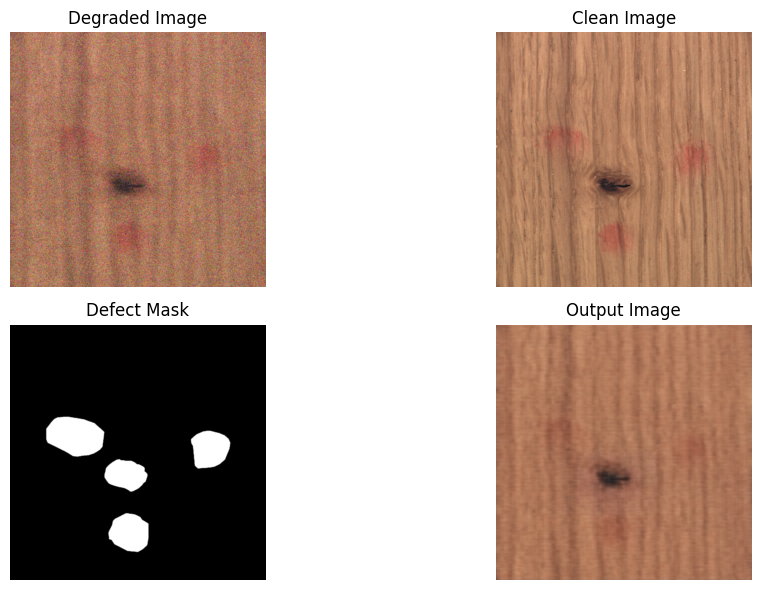

torch.Size([3, 256, 256])


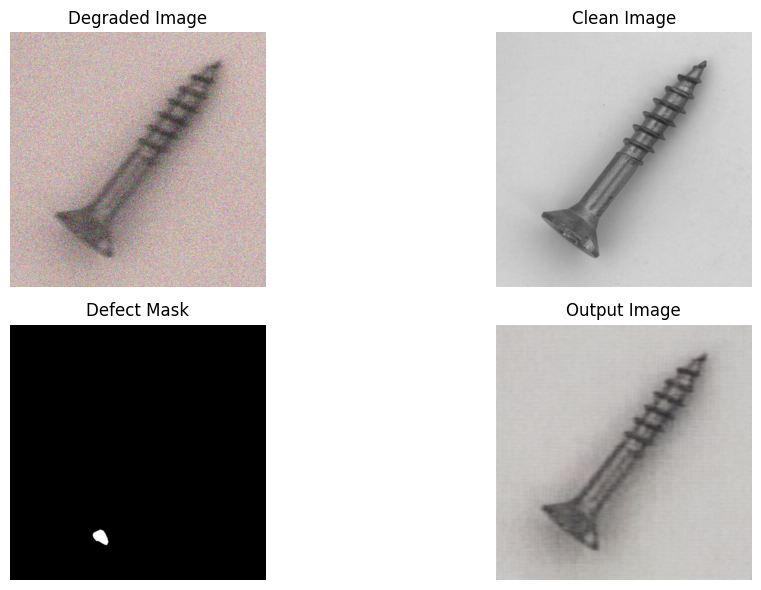

torch.Size([3, 256, 256])


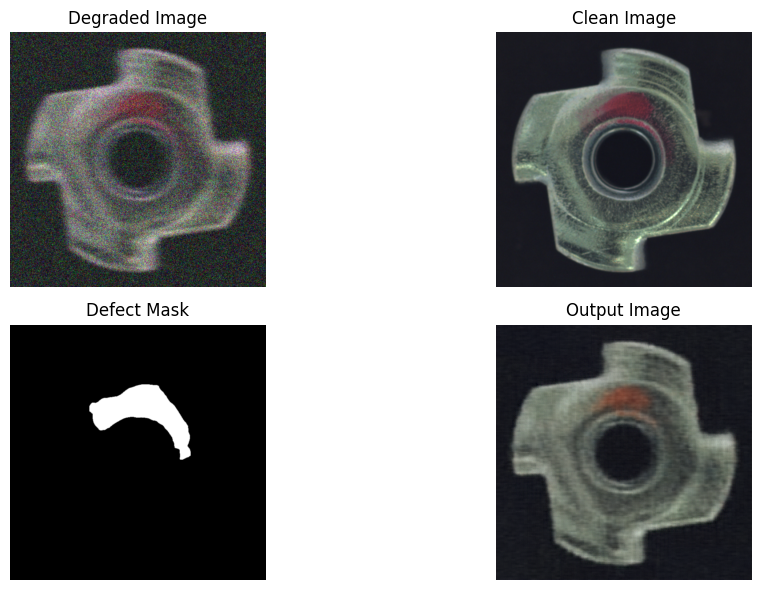

torch.Size([3, 256, 256])


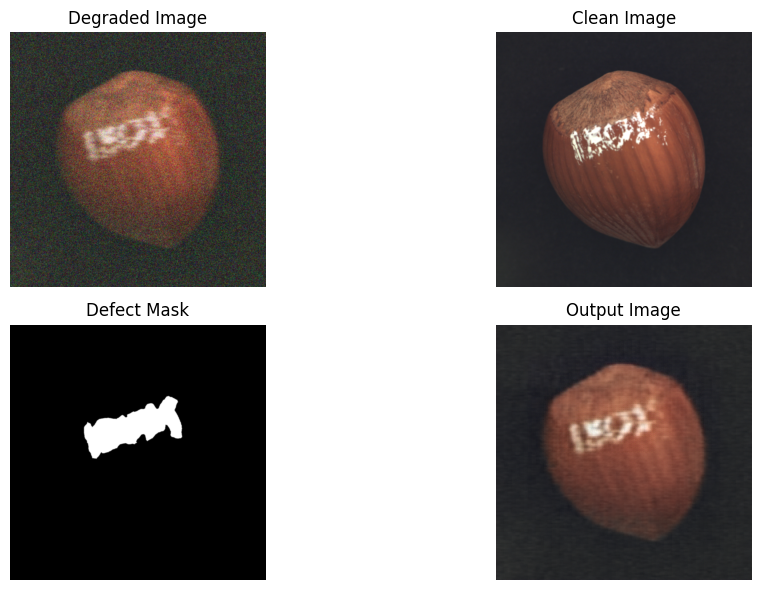

torch.Size([3, 256, 256])


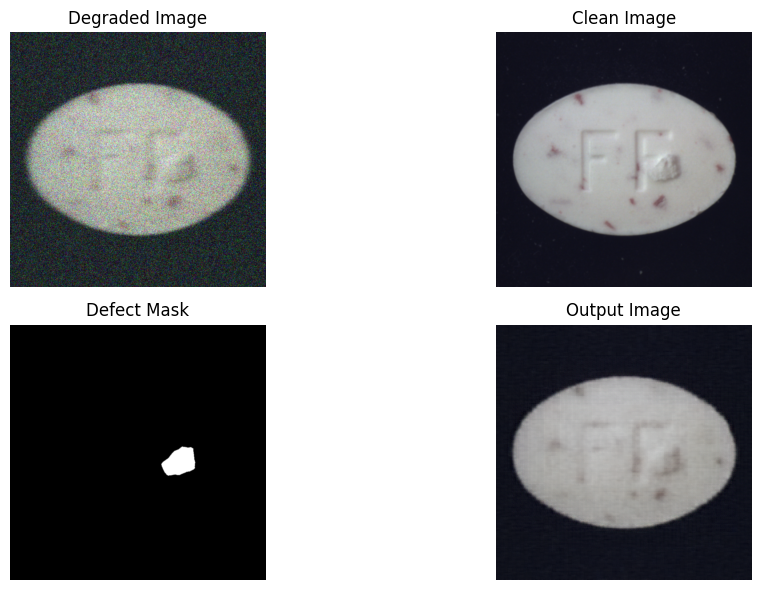

torch.Size([3, 256, 256])


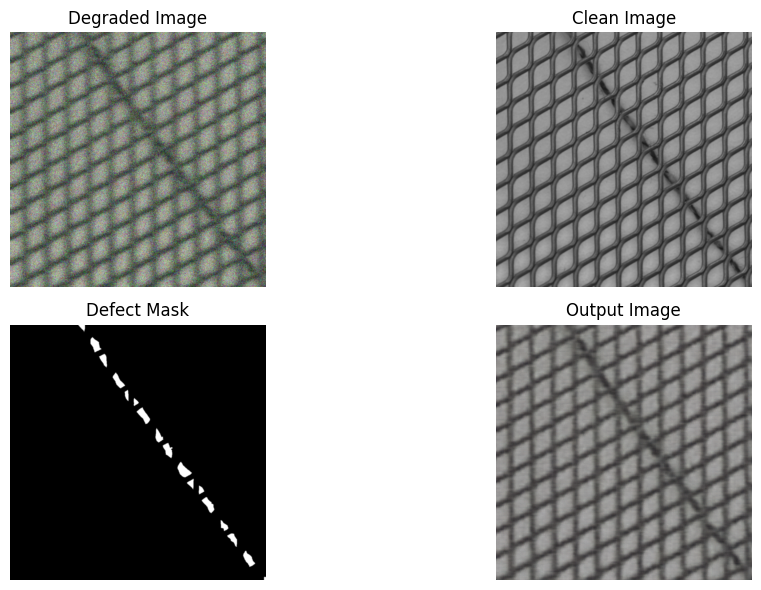

torch.Size([3, 256, 256])


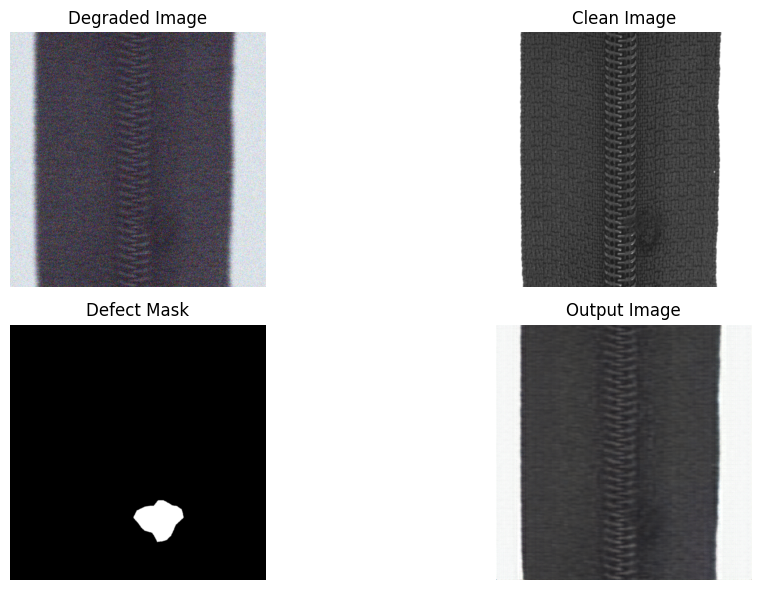

torch.Size([3, 256, 256])


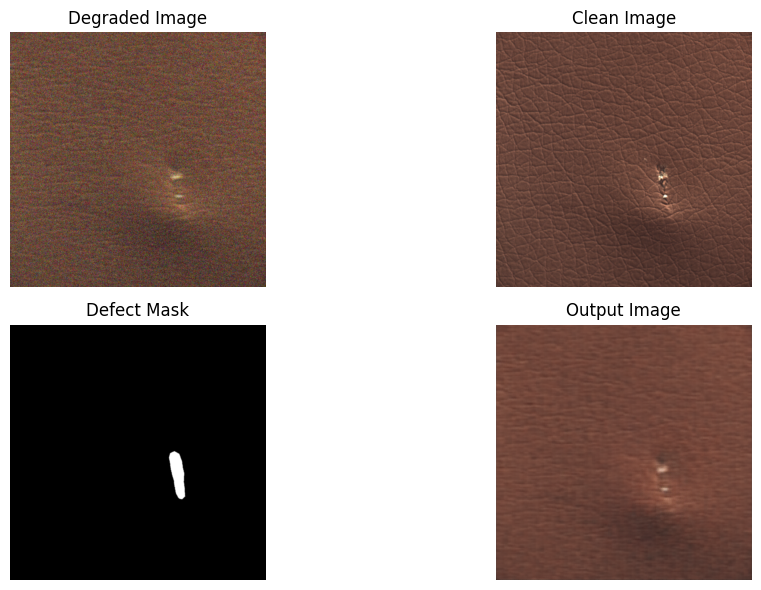

torch.Size([3, 256, 256])


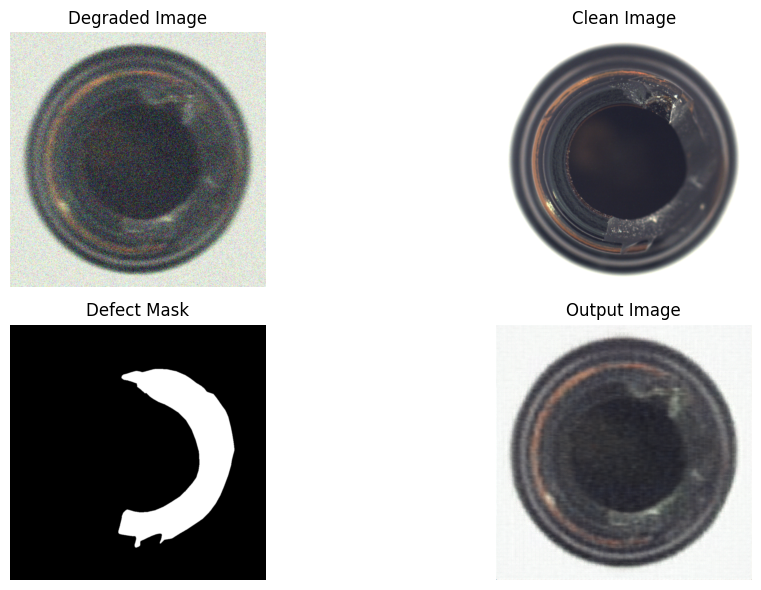

torch.Size([3, 256, 256])


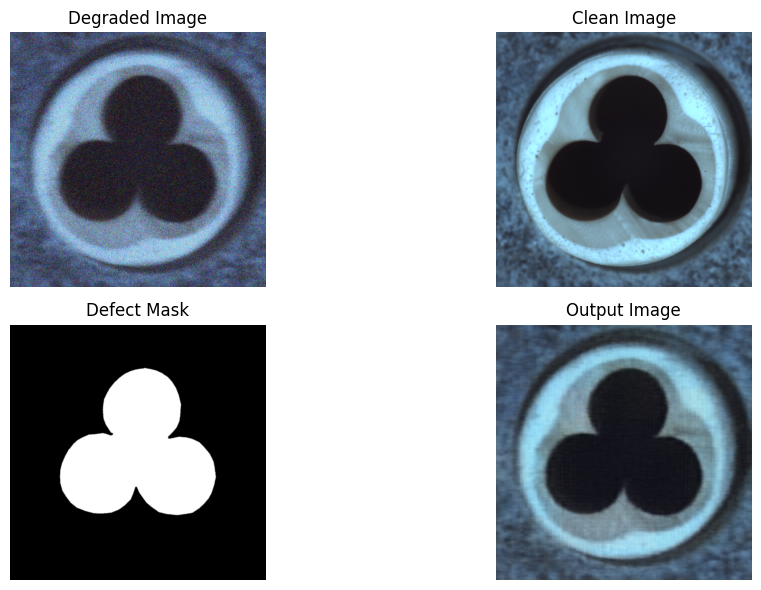

In [39]:
for sample in sample_data:
    degraded, clean, defect_mask = sample
    degraded = degraded.to(device)
    degraded = degraded.unsqueeze(0)
    output_image = model(degraded)
    output_image = output_image.squeeze(0)
    print(output_image.shape)
    display_images(degraded, clean, defect_mask, output_image)